### Importing relevant Libraries :

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
import math
from sklearn.model_selection import GridSearchCV


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set()

In [ ]:
# Reading csv file and setting matrix as a dataframe. 
import pandas as pd

df1 = pd.read_csv('./mami_data_file.csv', sep = ',', parse_dates=True)
dfgenos = pd.read_csv('./Female_genos.csv', sep = ',', parse_dates=True)

dfgenos.dropna(how = 'all')

df = pd.merge(df1,dfgenos,on= 'Dnumber')


In [ ]:
cleanup = {'CaConRel':{1: 0, 2: 1, 3 : ' '},'q_15':{'15b':0, '15a':1}}

df.replace(cleanup, inplace=True)

# The empty spaces are being replaced to NaNs i.e. missing values
df.replace(' ', np.NaN, inplace=True)

df.rename(columns = {'q_15':'Smoke_status'}, inplace = True)

### Determining the variables of interest:

In [ ]:
# Working on a subset of the dataset. This is needed before removing the missing 
# values so that most of the rows are still conserved

cols_tobe_selected = pd.concat([df.iloc[:,162:len(df.columns)],df[['TRIG_FOL_ALL','Age','Gender', 'CaConRel','Smoke_status','CHOL','q_132_1_Syst','q_132_2_Syst','rs2305948', 'rs1801177', 'rs45539933','rs11669576', 'rs9527025', 'rs533617','rs11466653']]],axis= 1)

working_df = cols_tobe_selected.dropna()
working_df.reset_index(drop=True, inplace=True)


In [ ]:
# specifying females only
working_df_females = working_df[working_df['Gender'] == '1']


In [ ]:
# Setting specific columns as numeric instead of object

obj_to_numeric_cols = ['Age','TRIG_FOL_ALL','CaConRel','CHOL','q_132_1_Syst','q_132_2_Syst']

working_df_females[obj_to_numeric_cols]= working_df_females[obj_to_numeric_cols].apply(pd.to_numeric)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Setting specific columns as string instead of float

num_to_obj_cols = working_df_females.loc[:, ~working_df_females.columns.isin(obj_to_numeric_cols)].columns

working_df_females[num_to_obj_cols]= working_df_females[num_to_obj_cols].astype(str)


In [ ]:
# Getting the mean systolic bp by adding Syst_bp_1 to Syst_bp_2 and diving by 2 in another column
working_df_females['Avr_syst']= working_df_females[['q_132_1_Syst','q_132_2_Syst']].mean(axis = 1)

<ipython-input-9-7fb33d0c6579>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df_females['Avr_syst']= working_df_females[['q_132_1_Syst','q_132_2_Syst']].mean(axis = 1)


### Creating Dummy Variables :

In [ ]:
# Dummies created automatically for the object type variables. Original variables
# are dropped to folow the N-1 rule 

working_df_females = pd.get_dummies(working_df_females, drop_first=True)
working_df_females.columns


Index(['TRIG_FOL_ALL', 'Age', 'CaConRel', 'CHOL', 'q_132_1_Syst',
       'q_132_2_Syst', 'Avr_syst', 'rs1800774_2', 'rs1800774_3',
       'rs10940498_2', 'rs10940498_3', 'rs328_2', 'rs328_3', 'rs1799930_2',
       'rs1799930_3', 'rs143673595_2', 'rs143673595_3', 'rs1043941_2',
       'rs1043941_3', 'rs482548_2', 'rs482548_3', 'rs11620_2', 'rs11620_3',
       'rs1532625_2', 'rs1532625_3', 'rs10558187_2', 'rs10558187_3',
       'rs1041983_2', 'rs1041983_3', 'Smoke_status_1.0', 'rs2305948_2',
       'rs2305948_3', 'rs1801177_2', 'rs45539933_2', 'rs45539933_3',
       'rs11669576_2', 'rs11669576_3', 'rs9527025_2', 'rs9527025_3',
       'rs533617_2', 'rs11466653_2'],
      dtype='object')

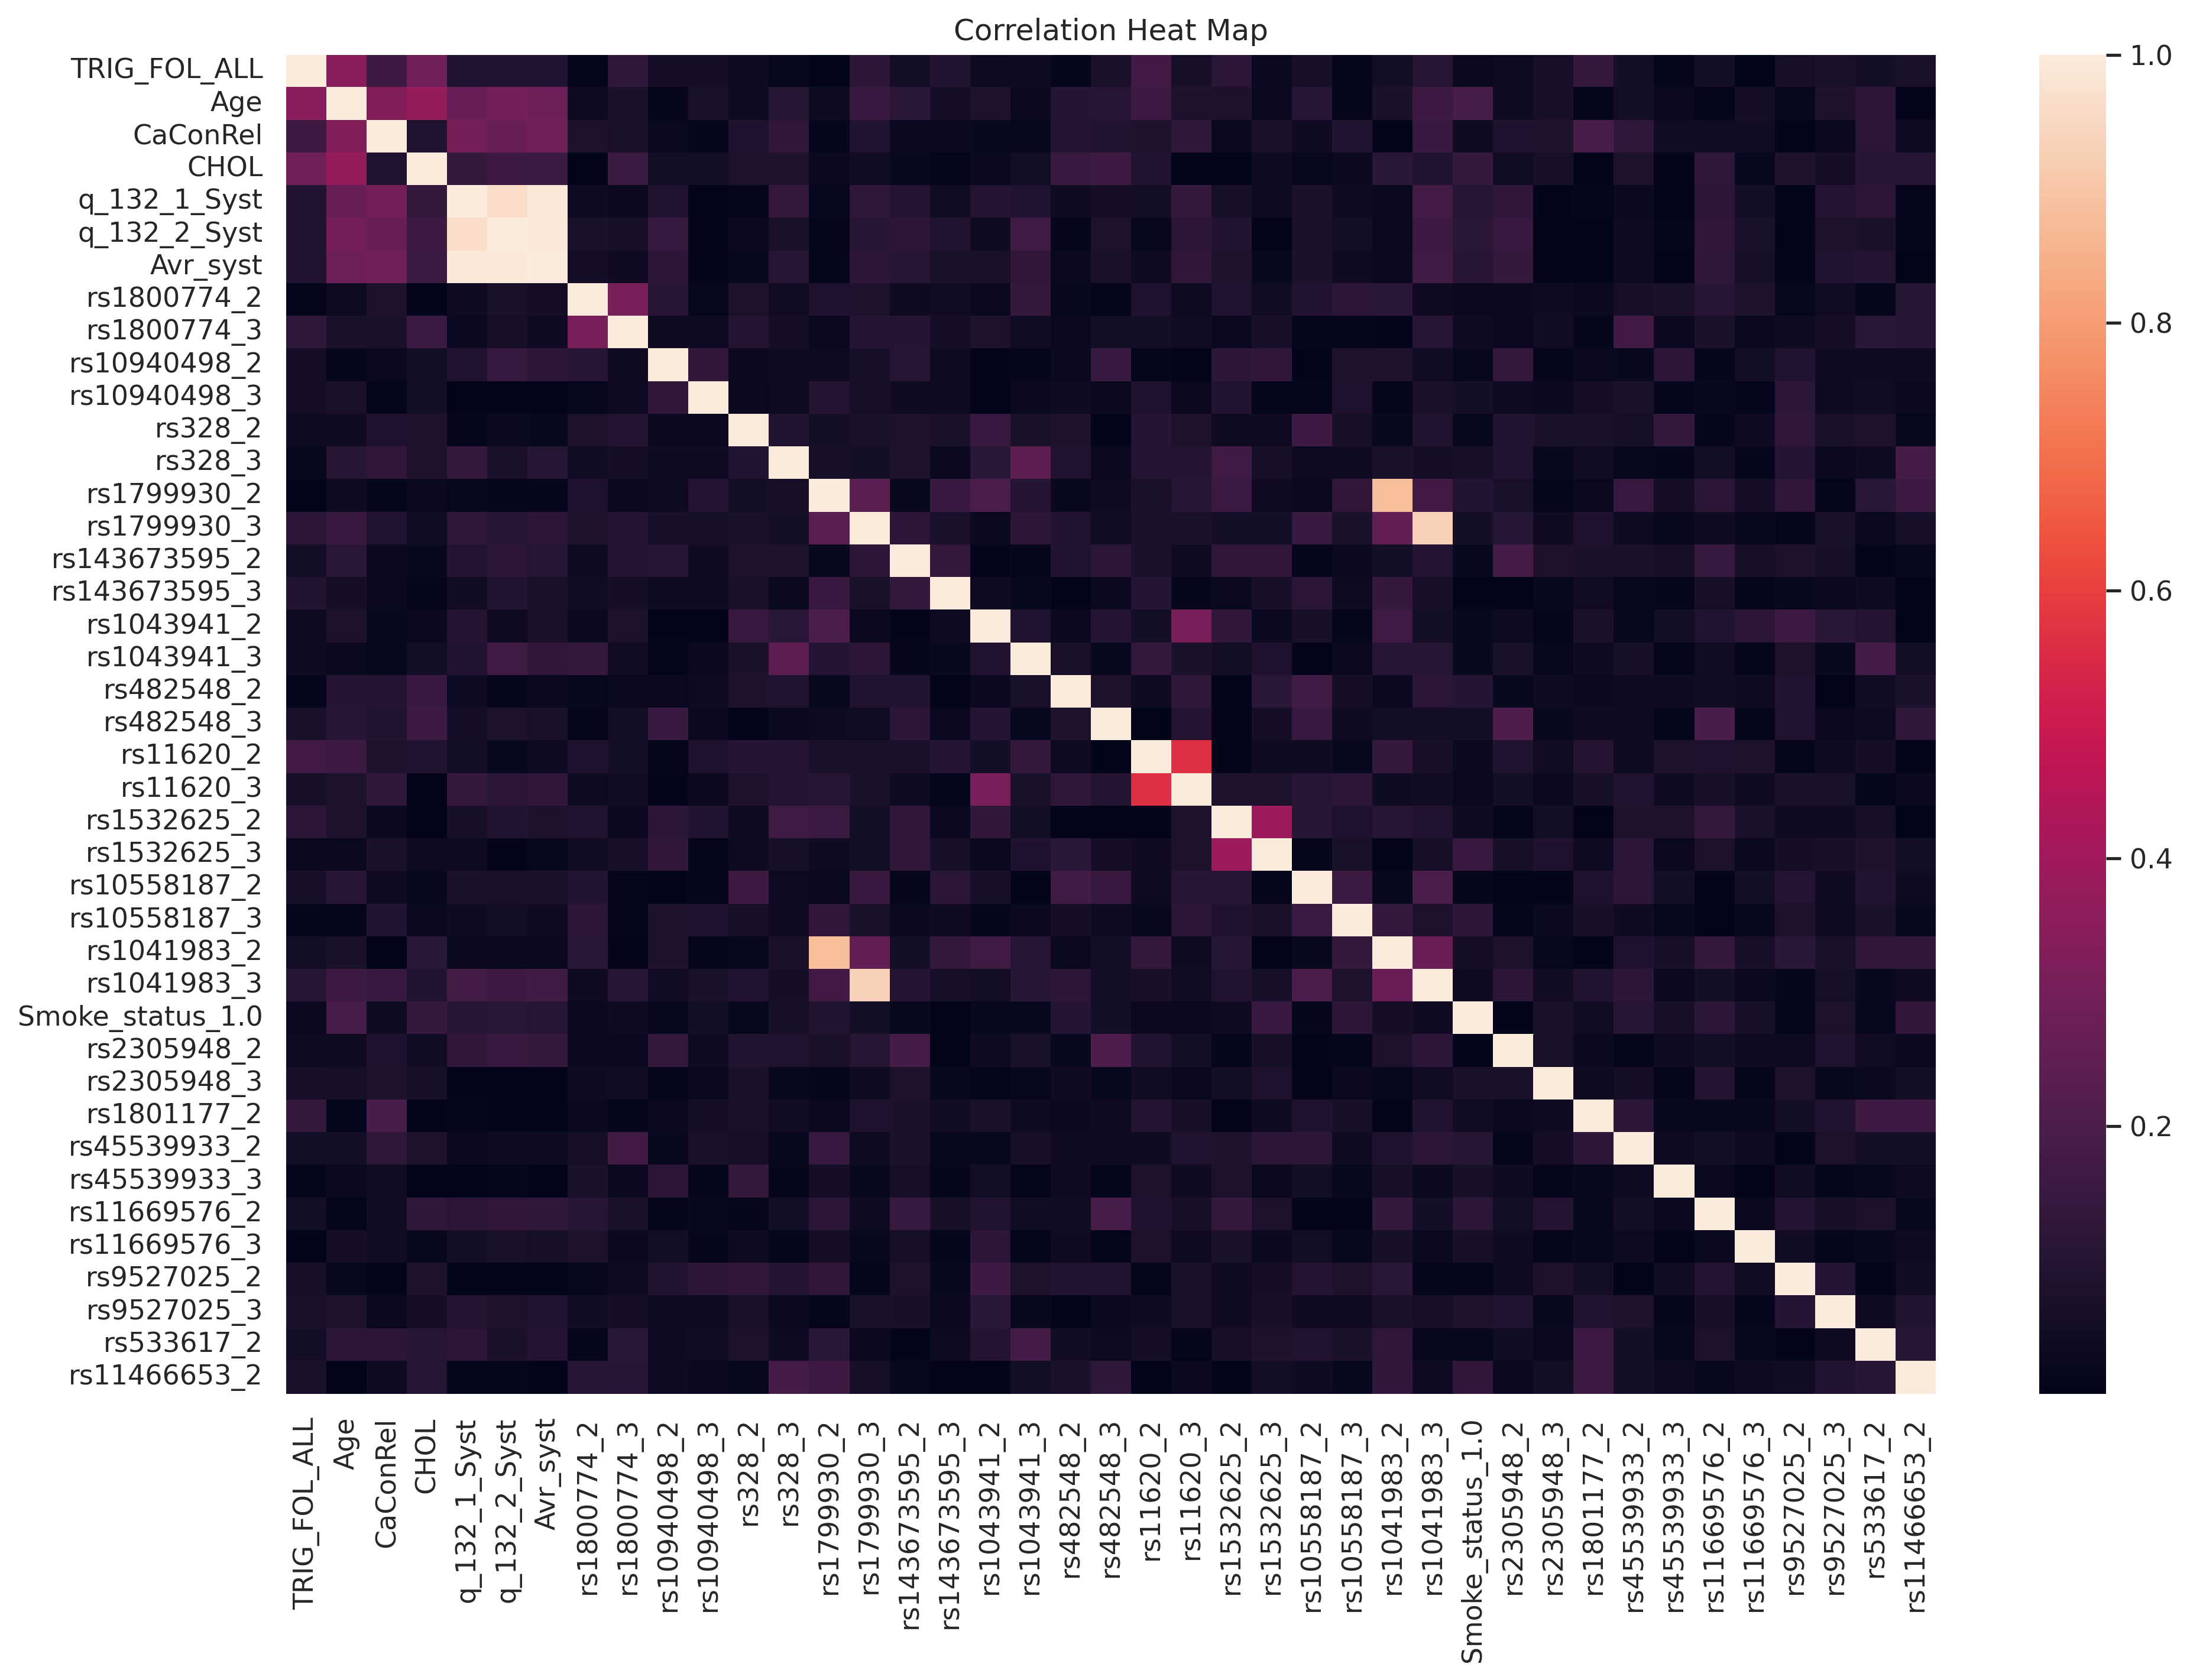

In [ ]:
# Correlation Heatmap

plt.figure(figsize=(15, 10))
sns.heatmap(abs(working_df_females.corr()))
plt.title("Correlation Heat Map");

In [ ]:
inputs_cases = working_df_females[working_df_females['CaConRel'] == 1]
inputs_ctrls = working_df_females[working_df_females['CaConRel'] == 0]


In [ ]:
# Declaring the Inputs (Predictors) and Target

targets_cases = inputs_cases['TRIG_FOL_ALL']
targets_ctrls = inputs_ctrls['TRIG_FOL_ALL']

inputs_cases = inputs_cases.drop(['TRIG_FOL_ALL','CaConRel','q_132_1_Syst', 'q_132_2_Syst'],axis =1)
inputs_ctrls = inputs_ctrls.drop(['TRIG_FOL_ALL','CaConRel','q_132_1_Syst', 'q_132_2_Syst'],axis =1)

cols_for_scaling_cases = inputs_cases.loc[:, ~inputs_cases.columns.isin(['Age','CHOL','Avr_syst'])].columns
cols_for_scaling_ctrls = inputs_ctrls.loc[:, ~inputs_ctrls.columns.isin(['Age','CHOL','Avr_syst'])].columns


In [ ]:
# Controls are split into training and testing sets. The training set (80%) will be used to train the model and the testing set will be concatenated with the 
# cases to test the model and get the predicted triglycerides(TG).

inputs_ctrls_train, inputs_ctrls_test, targets_ctrls_train, targets_ctrls_test = train_test_split(inputs_ctrls, targets_ctrls, train_size = .8, random_state = 999)

In [ ]:
# Test_set and test_target_set will be used to get the predicted TG for both cases and controls

test_set = pd.concat([inputs_ctrls_train, inputs_ctrls_test, inputs_cases])
test_target_set = pd.concat([targets_ctrls_train, targets_ctrls_test, targets_cases])


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


inputs_ctrls_test_scaled = scaler.fit_transform(inputs_ctrls_test[['Age','CHOL','Avr_syst']])
inputs_ctrls_test_scaled_df = pd.DataFrame(data=inputs_ctrls_test_scaled, columns= ['Age','CHOL','Avr_syst'], index=inputs_ctrls_test.index) 
inputs_ctrls_test = pd.concat([inputs_ctrls_test_scaled_df, inputs_ctrls_test[cols_for_scaling_ctrls]], axis=1)

# 

inputs_ctrls_scaled = scaler.fit_transform(inputs_ctrls_train[['Age','CHOL','Avr_syst']])
inputs_ctrls_scaled_df = pd.DataFrame(data=inputs_ctrls_scaled, columns= ['Age','CHOL','Avr_syst'], index=inputs_ctrls_train.index) 
inputs_ctrls_train = pd.concat([inputs_ctrls_scaled_df, inputs_ctrls_train[cols_for_scaling_ctrls]], axis=1)

##

inputs_cases_scaled = scaler.fit_transform(test_set[['Age','CHOL','Avr_syst']])
inputs_cases_scaled_df = pd.DataFrame(data=inputs_cases_scaled, columns= ['Age','CHOL','Avr_syst'], index=test_set.index) 
inputs_cases = pd.concat([inputs_cases_scaled_df, test_set[cols_for_scaling_cases]], axis=1)


In [ ]:
#x_train and y_train = 80% of controls to train the model

x_test = inputs_cases 
x_train = inputs_ctrls_train 


y_test = test_target_set
y_train = targets_ctrls_train


In [ ]:
# LINEAR and NON-LINEAR model comparison

In [ ]:
# Fitting the Regression Model using the training dataset
# Uncomment to run a different regression model

# reg = LinearRegression().fit(x_train, y_train)
# reg = RandomForestRegressor(random_state=999,max_depth=14, max_features='sqrt', max_leaf_nodes=4,
#                       max_samples=0.2, min_samples_leaf=2, min_samples_split=6,
#                       n_estimators=10).fit(x_train, y_train)
# reg = MLPRegressor(random_state=999, alpha=0.1, hidden_layer_sizes=(10, 10)).fit(x_train, y_train)
reg = SVR(C=1, kernel='linear').fit(x_train, y_train)


In [ ]:

# Create the parameter grid based on the results of random search 

rf_param_grid = {
    'max_depth': [12, 14, 16, 18],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [2,4,6],
    'min_samples_split': [2,4,6],
    'n_estimators': [10, 20, 30, 40],
    'max_leaf_nodes': [2,4,6],
    'max_samples': [0.2, 0.4, 0.6]
}
# Create a based model
rf_model = RandomForestRegressor()

In [ ]:
svr_param_grid = {
    'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'), 
    'C' : [0.0001, 0.001, 0.01, 1], 
}

svr_model = SVR()

In [ ]:
mlp_param_grid = {
    "hidden_layer_sizes": [(80,40), (40,40),(40,20), (20,10), (10,10)], 
    "alpha": [1e-05,1e-04, 1e-03 ,1e-02,1e-01, 1]
}

mlp_model = MLPRegressor()

In [ ]:
# # Initiate the grid search model
grid_search = GridSearchCV(estimator = svr_model, param_grid = svr_param_grid, 
                           scoring= {'mae': make_scorer(mean_absolute_error), 
                                     'r2': make_scorer(r2_score), 
                                     'mse': make_scorer(mean_squared_error)},
                           refit='mae', cv = 2, n_jobs = -1, verbose = 2)

# # Fit the grid search to the data
grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             refit='mae',
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)},
             verbose=2)

In [ ]:
# Calculating and adding RMSE to the resulting dataframe using the MSE

cv_df = pd.DataFrame(grid_search.cv_results_)
cv_df['mean_test_rmse']= cv_df['mean_test_mse']**(1/2)
cv_df['split0_test_rmse']= cv_df['split0_test_mse']**(1/2)
cv_df['split1_test_rmse']= cv_df['split1_test_mse']**(1/2)

In [ ]:

# UNCOMMENT FOR MLP plots
# fig = plt.figure()
# ax1 = fig.add_subplot()

# ax1.scatter(cv_df['param_hidden_layer_sizes'].astype(str),cv_df['split1_test_rmse'], alpha = 0.3, label = 'Second Fold RMSE')
# ax1.scatter(cv_df['param_hidden_layer_sizes'].astype(str),cv_df['split0_test_rmse'], alpha =0.4, label = 'First Fold RMSE')
# plt.legend(loc='upper right')
# plt.ylabel('RMSE')
# plt.xlabel('Hidden layer sizes')
# plt.title('RMSE values with increasing hidden layer size')
# plt.show()

# plt.scatter(cv_df['param_activation'],cv_df['mean_test_rmse'], alpha = 0.3)
# plt.ylabel('RMSE')
# plt.xlabel('Activation function')
# plt.title('RMSE values with different activation functions')
# plt.show()

# UNCOMMENT FOR RF plots
# fig = plt.figure()
# ax1 = fig.add_subplot()

# plt.scatter(cv_df['param_n_estimators'],cv_df['mean_test_rmse'], alpha = 0.3)
# plt.ylabel('RMSE')
# plt.xlabel('Number of trees (n_estimators)')
# plt.title('RMSE values with number of trees')
# plt.show()

# plt.scatter(cv_df['param_n_estimators'],cv_df['mean_test_r2'], alpha = 0.3)
# plt.ylabel('R2')
# plt.xlabel('Number of trees (n_estimators)')
# plt.title('R2 values with number of trees')
# plt.show()

# UNCOMMENT FOR SVR plots

# fig, ax = plt.subplots(1, figsize=(10, 10))
# sns.boxplot(x = cv_df['param_C'].astype(str),y= cv_df['mean_test_r2'], width=0.6, palette="Blues")
# plt.ylabel('R2', size =15)
# plt.xlabel('C', size =15)
# plt.title('R2 values with increasing C values',size =15)
# plt.show()

# fig, ax = plt.subplots(1, figsize=(10, 10))
# sns.boxplot(x = cv_df['param_kernel'].astype(str),y= cv_df['mean_test_r2'], width=0.6, palette="Blues")
# plt.ylabel('R2', size =15)
# plt.xlabel('Kernel', size =15)
# plt.title('R2 values with changing kernel function',size =15)
# plt.show()

In [ ]:
grid_search.best_estimator_

SVR(C=1, kernel='linear')

In [ ]:
grid_search.best_params_

{'C': 1, 'kernel': 'linear'}

Testing Performance of Trained Regression Model

In [ ]:
# y_hat_train refers to the predictions using the training set
y_hat_train = reg.predict(x_train)

In [ ]:
# Predicting using 20% of the controls (validation set)
Pred_ctrls = reg.predict(inputs_ctrls_test)


In [ ]:
# Predict response of a combination of x_train and x_test (testing set)

x_conc = x_test
y_conc = test_target_set
y_hat_conc = reg.predict(x_conc)


In [ ]:
# training set (80% of controls)

print("RMSE:",math.sqrt(mean_squared_error(y_train, y_hat_train)))
print("MAE:", mean_absolute_error(y_train, y_hat_train))
print("R2:", r2_score(y_train, y_hat_train))

RMSE: 0.3919517361925766
MAE: 0.2625598051312607
R2: 0.44943537318345395


In [ ]:
# validation (20% of controls)

print("RMSE:",math.sqrt(mean_squared_error(targets_ctrls_test, Pred_ctrls)))
print("MAE:", mean_absolute_error(targets_ctrls_test, Pred_ctrls))
print("R2:", r2_score(targets_ctrls_test, Pred_ctrls))

RMSE: 0.6573983120539075
MAE: 0.48407549454470666
R2: -0.010907532091530614


In [ ]:
# testing set using a combination of all cases and controls together

print("RMSE:",math.sqrt(mean_squared_error(y_conc, y_hat_conc)))
print("MAE:", mean_absolute_error(y_conc, y_hat_conc))
print("R2:", r2_score(y_conc, y_hat_conc))

RMSE: 0.5743134033321549
MAE: 0.3841323216011525
R2: 0.05088304296176738


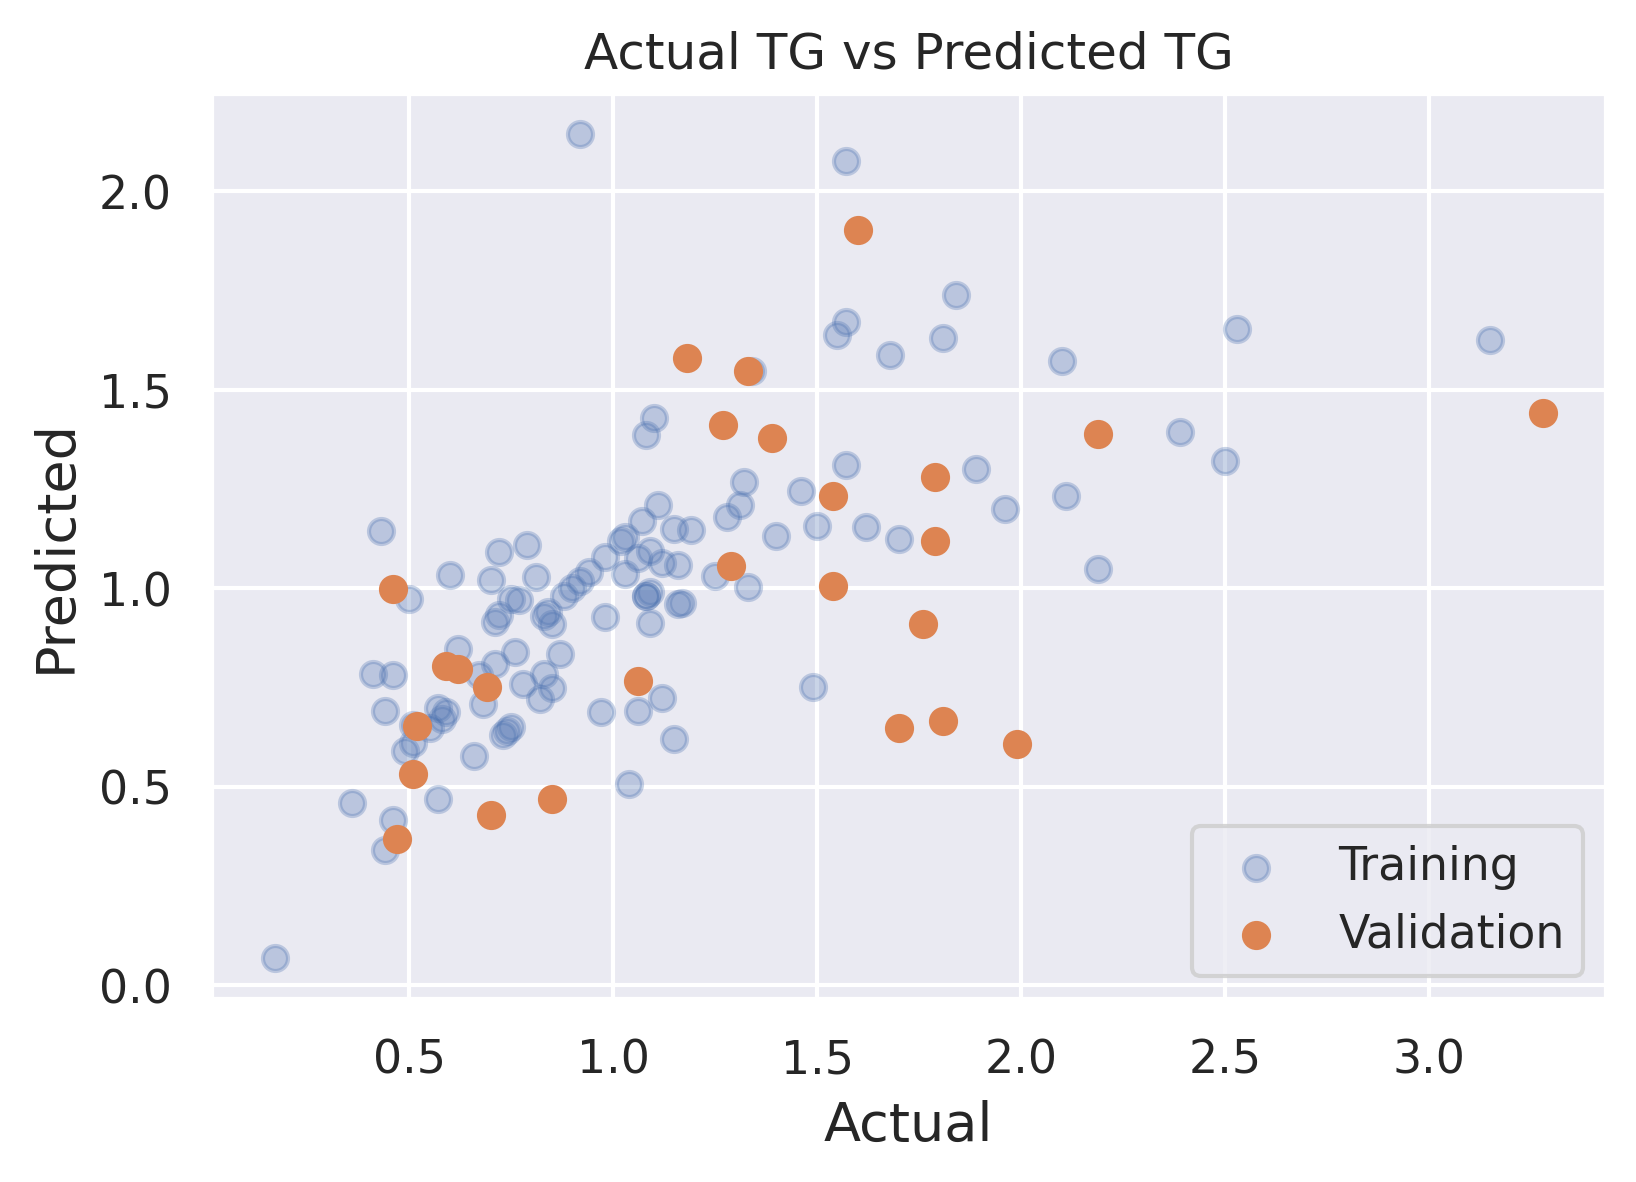

In [ ]:
# Plotting Actual vs Predicted scatter plot

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(y_train, y_hat_train, alpha = 0.3, label = 'Training')
ax1.scatter(targets_ctrls_test, Pred_ctrls, label = 'Validation')
plt.legend(loc='lower right')
plt.xlabel('Actual', size = 13);
plt.ylabel('Predicted', size = 13);
plt.title('Actual TG vs Predicted TG')
plt.show()

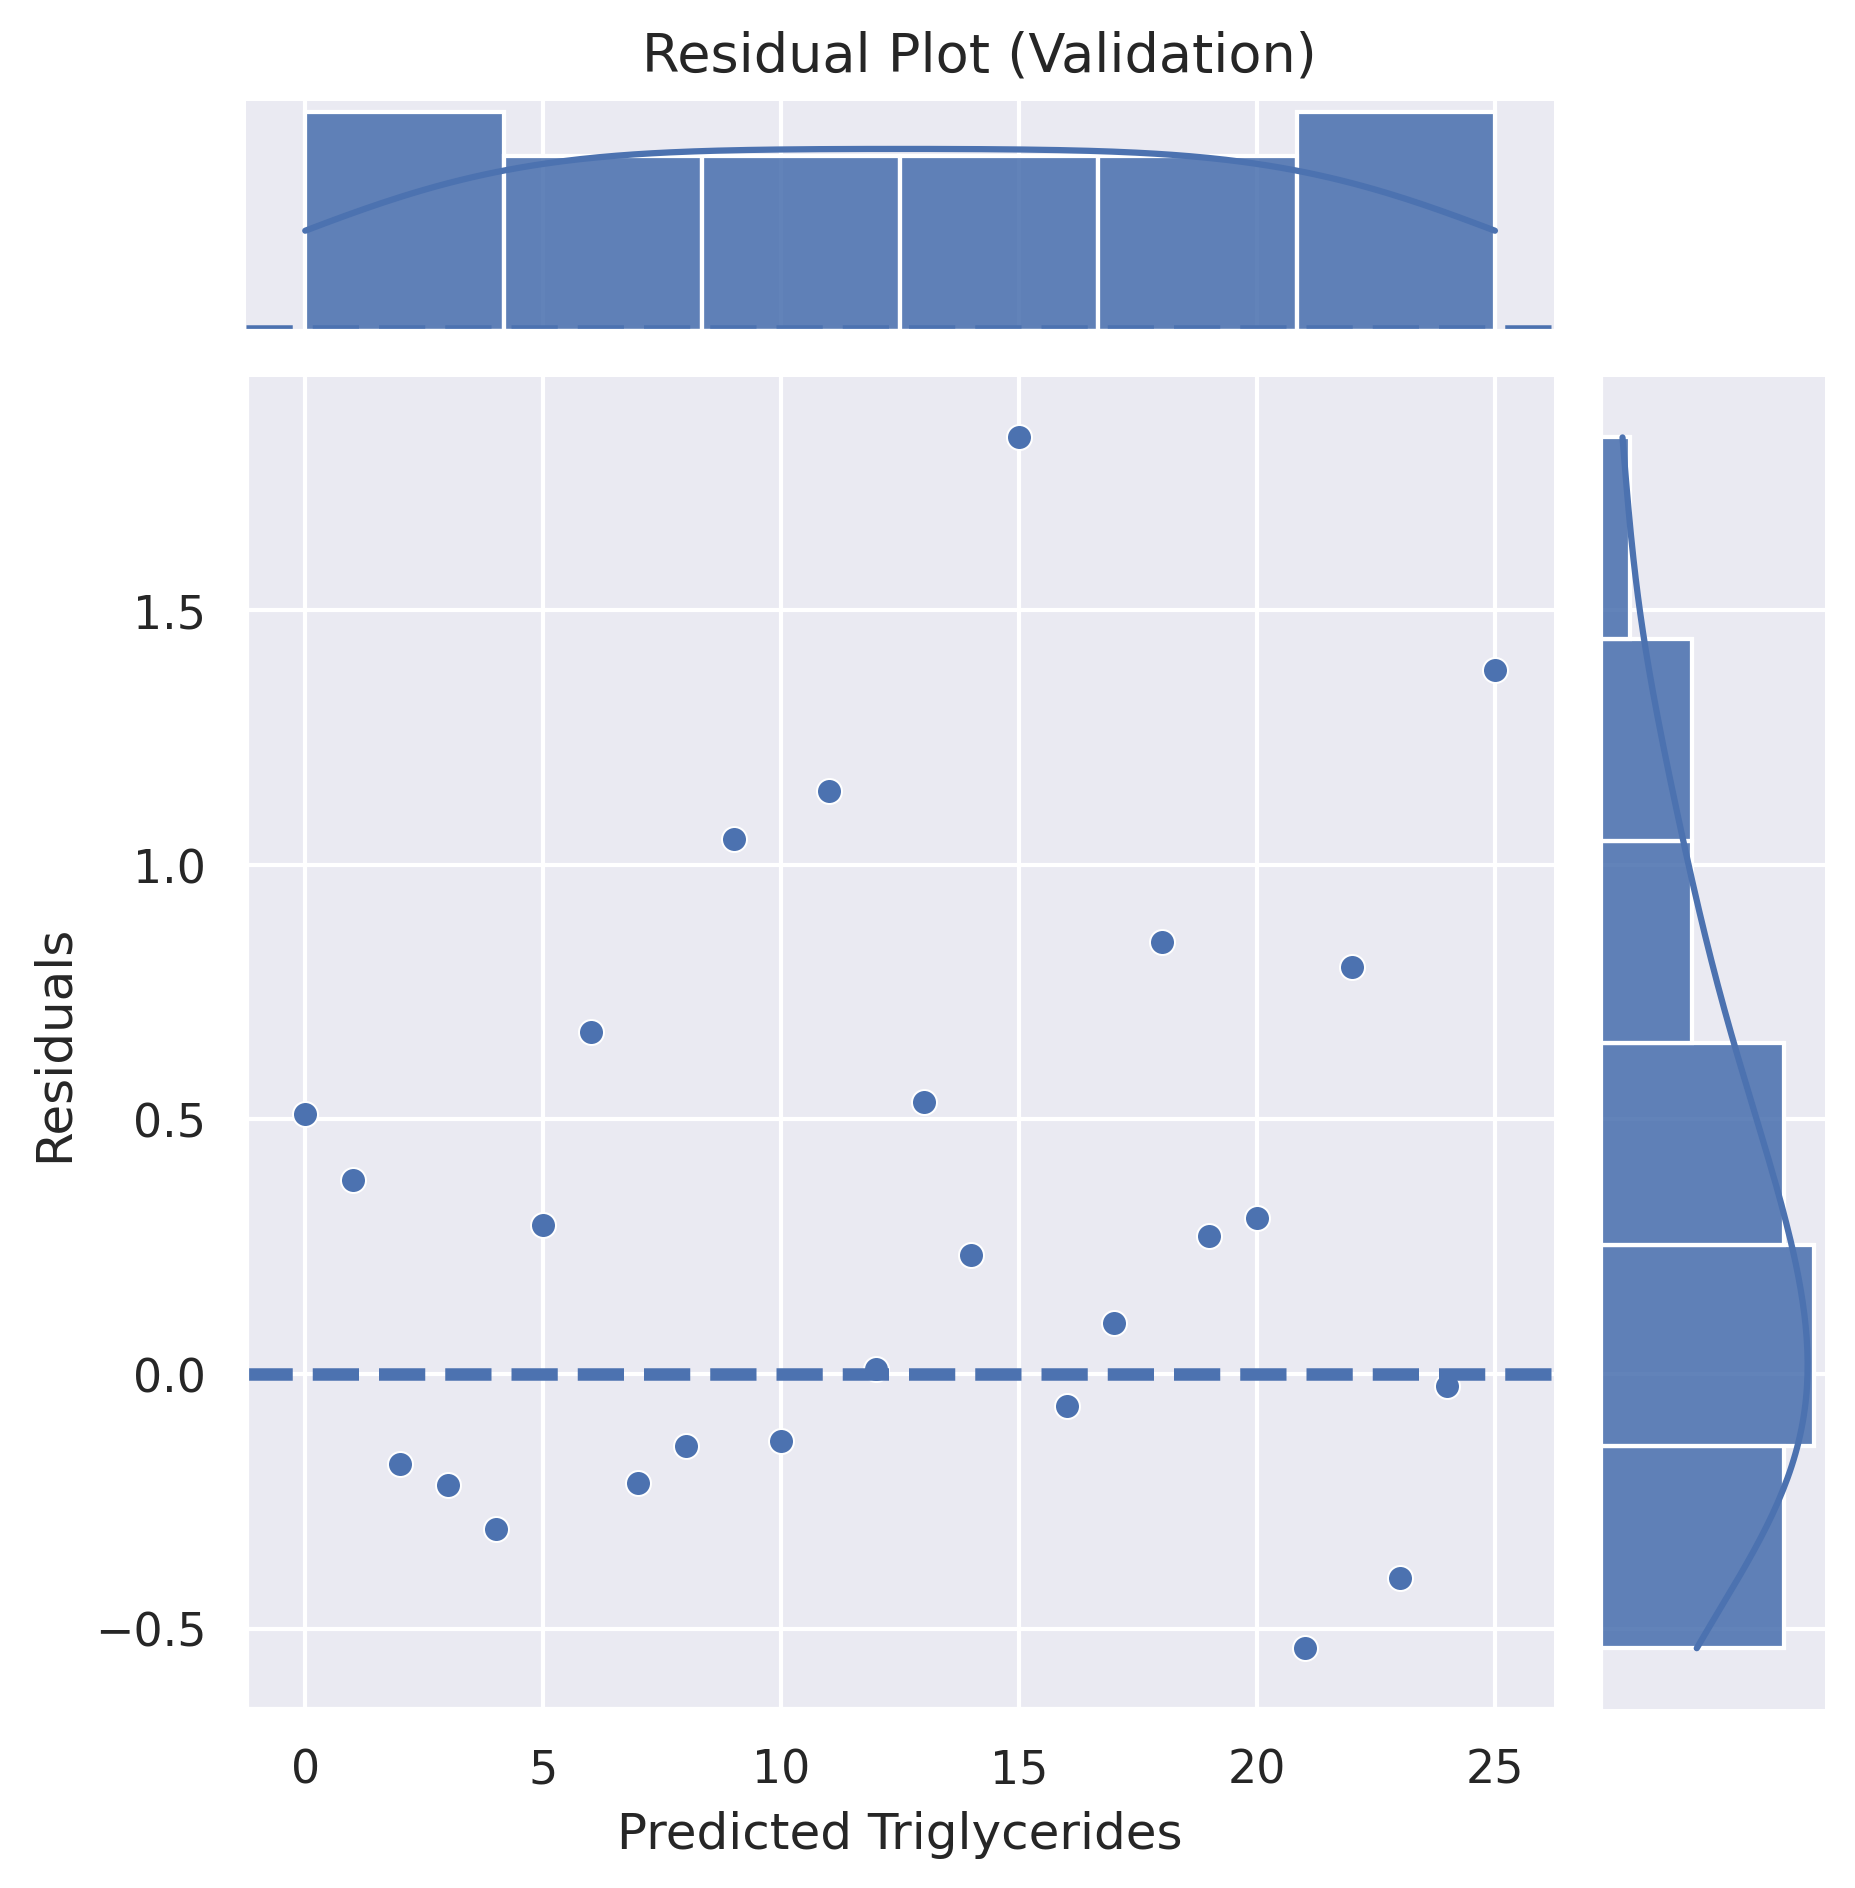

In [ ]:
# Plotting dist/scatter plot for residuals (testing 20%)

g=sns.jointplot(data = (targets_ctrls_test -Pred_ctrls).values).set_axis_labels('Predicted Triglycerides', 'Residuals')
g.fig.suptitle("Residual Plot (Validation)", y= 1.01, size = 13)
for ax in (g.ax_joint, g.ax_marg_x):
    ax.axhline(0, ls='--', lw=3)
g.plot_marginals(sns.histplot, kde=True)
plt.show()


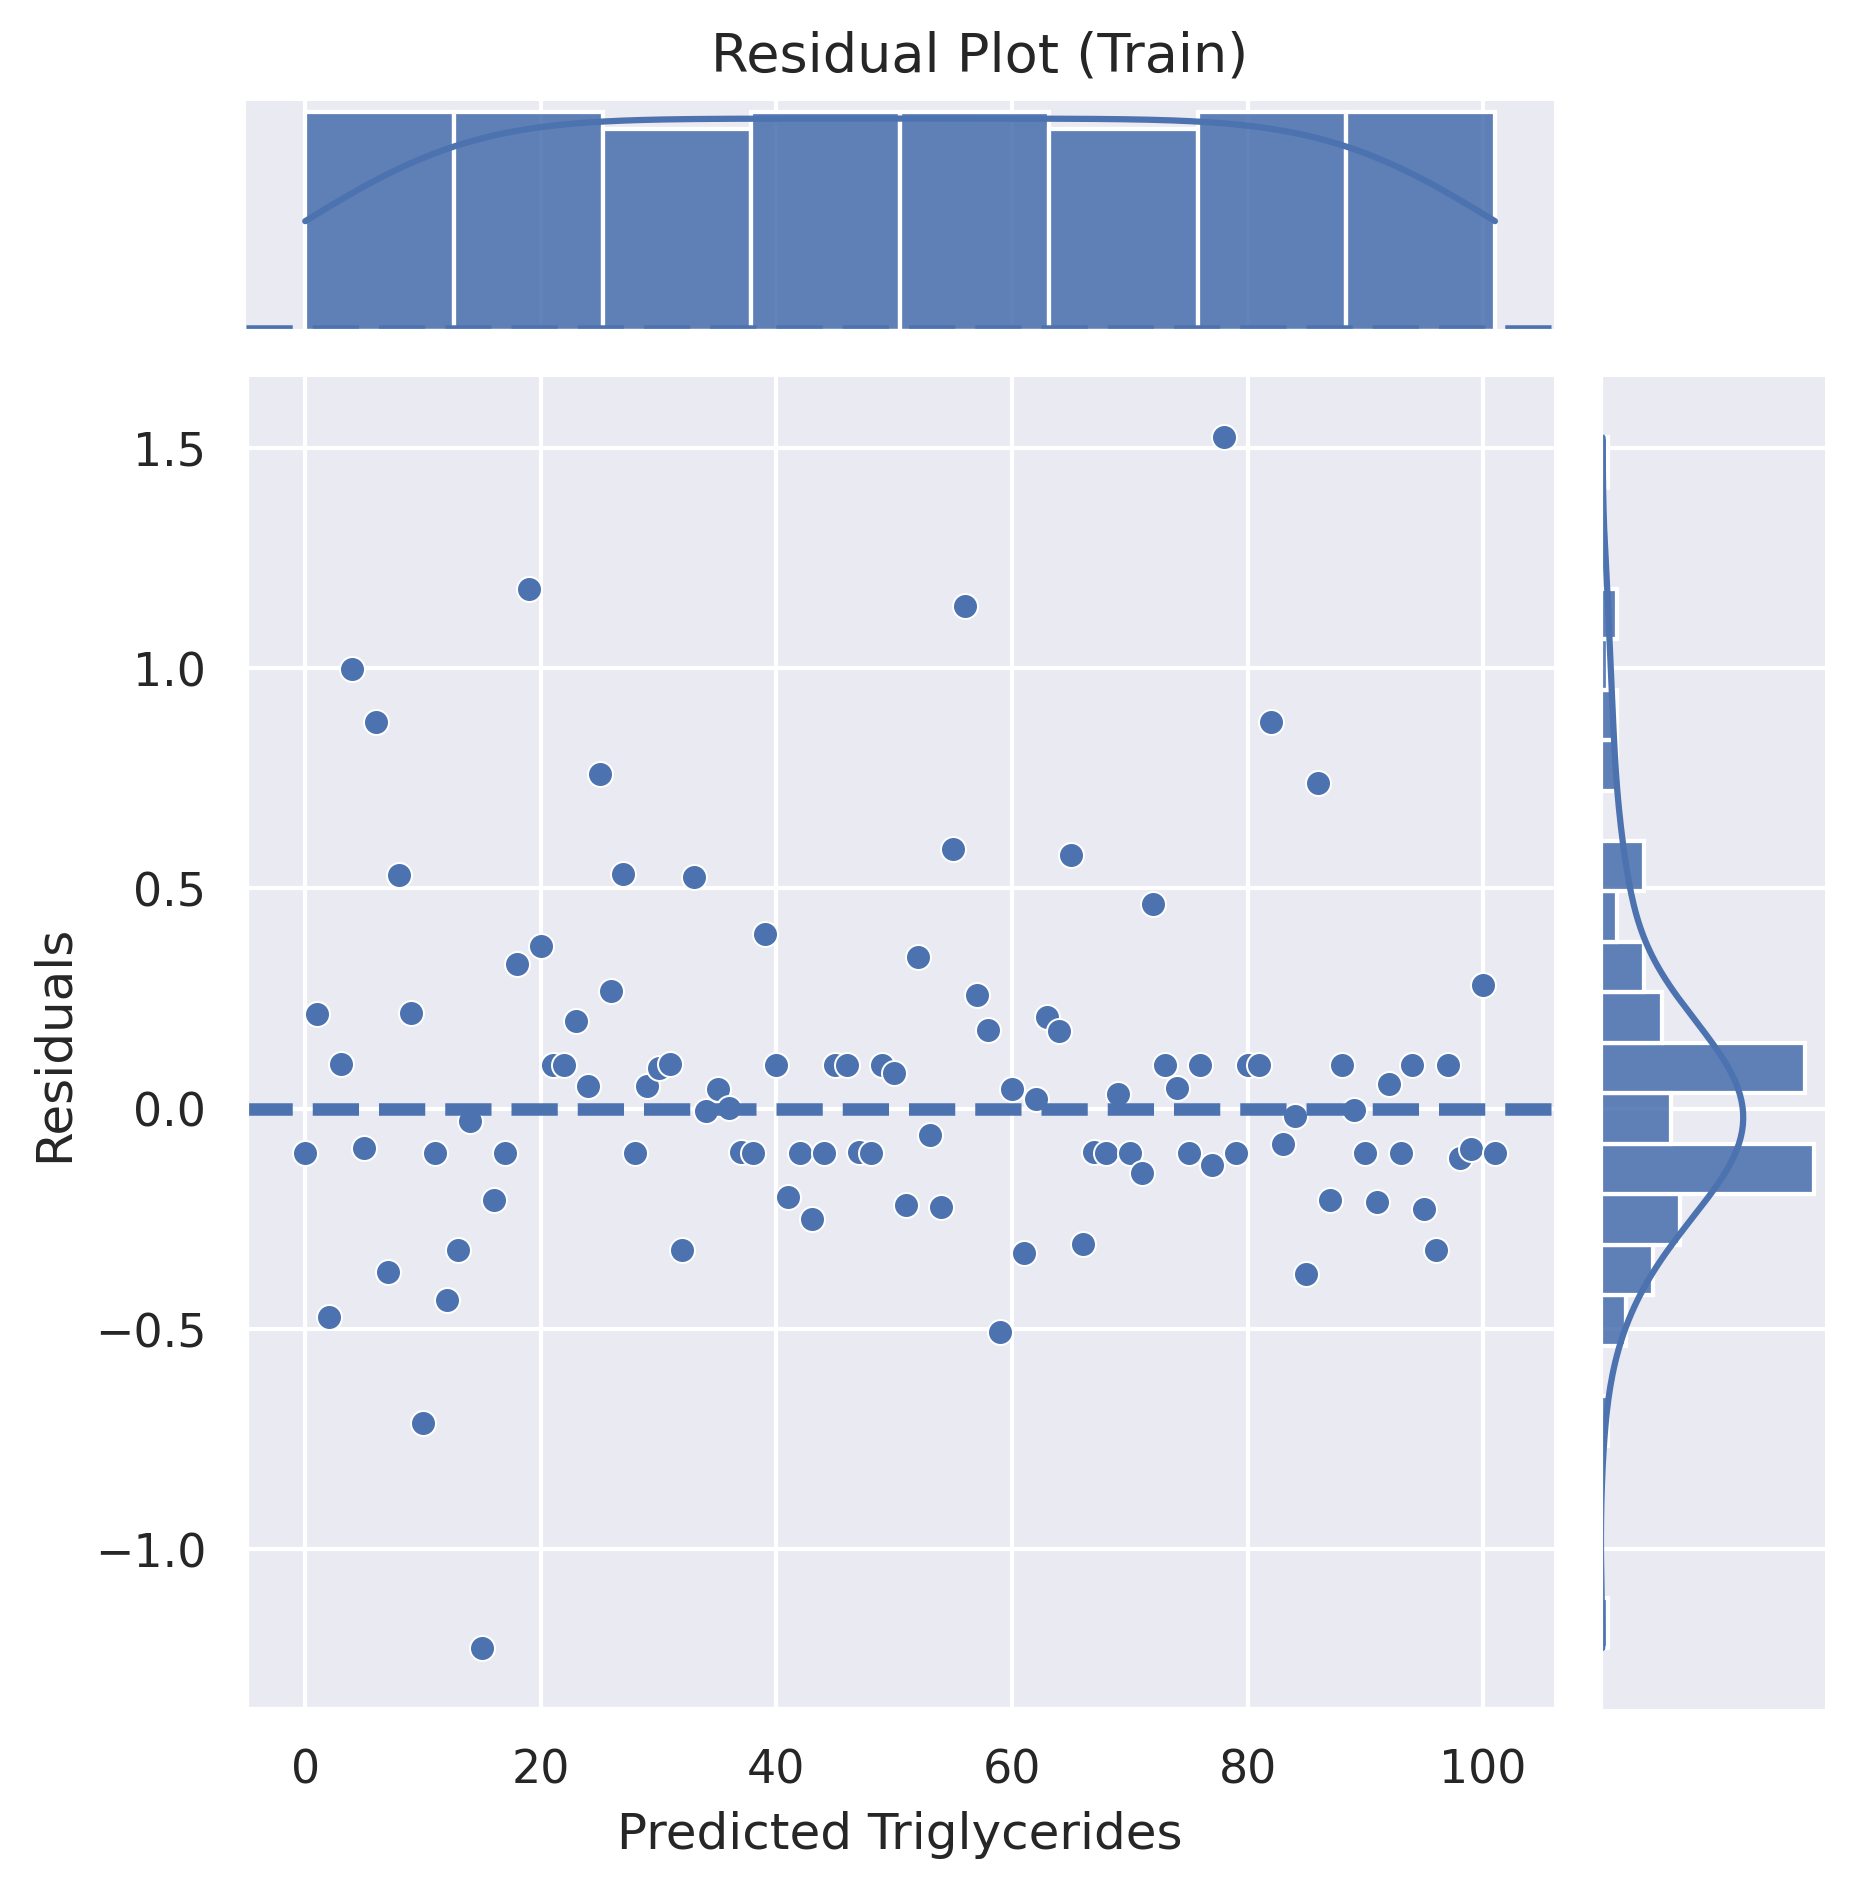

In [ ]:
# Plotting dist/scatter plot for residuals (training 80%)

g=sns.jointplot(data = (y_train- y_hat_train).values).set_axis_labels('Predicted Triglycerides', 'Residuals')
g.fig.suptitle("Residual Plot (Train)", y= 1.01, size = 13)
for ax in (g.ax_joint, g.ax_marg_x):
    ax.axhline(0, ls='--', lw=3)
g.plot_marginals(sns.histplot, kde=True)
plt.show()



Logistic Regression

Grouping the y_hat_conc into quartiles

In [ ]:
# y_hat_conc is split according to CaConRel value 0 (controls)

y_hat_conc_ctrl = y_hat_conc[working_df_females['CaConRel'][x_conc.index]==0]
y_hat_conc_cases = y_hat_conc[working_df_females['CaConRel'][x_conc.index]==1]


In [ ]:
# separated y_hat_conc_ctrl into quartiles. The intervals will be used to split y_hat_conc
pd.qcut(y_hat_conc_ctrl, q=4,labels=['1', 
                                '2', 
                                '3',  
                                '4']) 

testcut_series, testcut_intervals = pd.qcut(y_hat_conc_ctrl, q=4,labels=['1','2', '3','4'],retbins=True) 

testcut_intervals

array([0.09129908, 0.71849331, 0.99308233, 1.17994268, 2.12311276])

In [ ]:
GRS_TG = []

for i in y_hat_conc: 
  if i <= testcut_intervals[1]:
    GRS_TG.append(1)
  elif i <= testcut_intervals[2]:
    GRS_TG.append(2)
  elif i <= testcut_intervals[3]:
    GRS_TG.append(3)
  elif i > testcut_intervals[3]:
    GRS_TG.append(4)
  else:
    print('NaN')


GRS_TG_index = pd.DataFrame(index=x_conc.index)
GRS_TG_index['GRS'] = GRS_TG
GRS_TG_index.value_counts()


GRS
2      50
4      47
3      41
1      37
dtype: int64

Running Logistic Regression on the categorical variable GRS_TG.

In [ ]:
# getting the individuals(indices) from the Caconrel variable which correspond to the testing set indices. Thus, the cases.
target = working_df_females['CaConRel']

logreg_ytrain = target.loc[x_conc.index]


In [ ]:
# The predicted variable from the regression will be the used as the input in the logistic regression

logreg_xtrain = y_hat_conc


In [ ]:
#joining GRS_index with logreg_ytrain (they both have the same index)
#so that we can get the crosstabs i.e. the frequency of for example cases and controls
# in each GRS group
a = GRS_TG_index.join(pd.DataFrame(logreg_ytrain))

a.columns = ['GRS', 'CaConRel']
pd.crosstab(a['GRS'],a['CaConRel'])

CaConRel,0.0,1.0
GRS,,
1,32,5
2,32,18
3,32,9
4,32,15


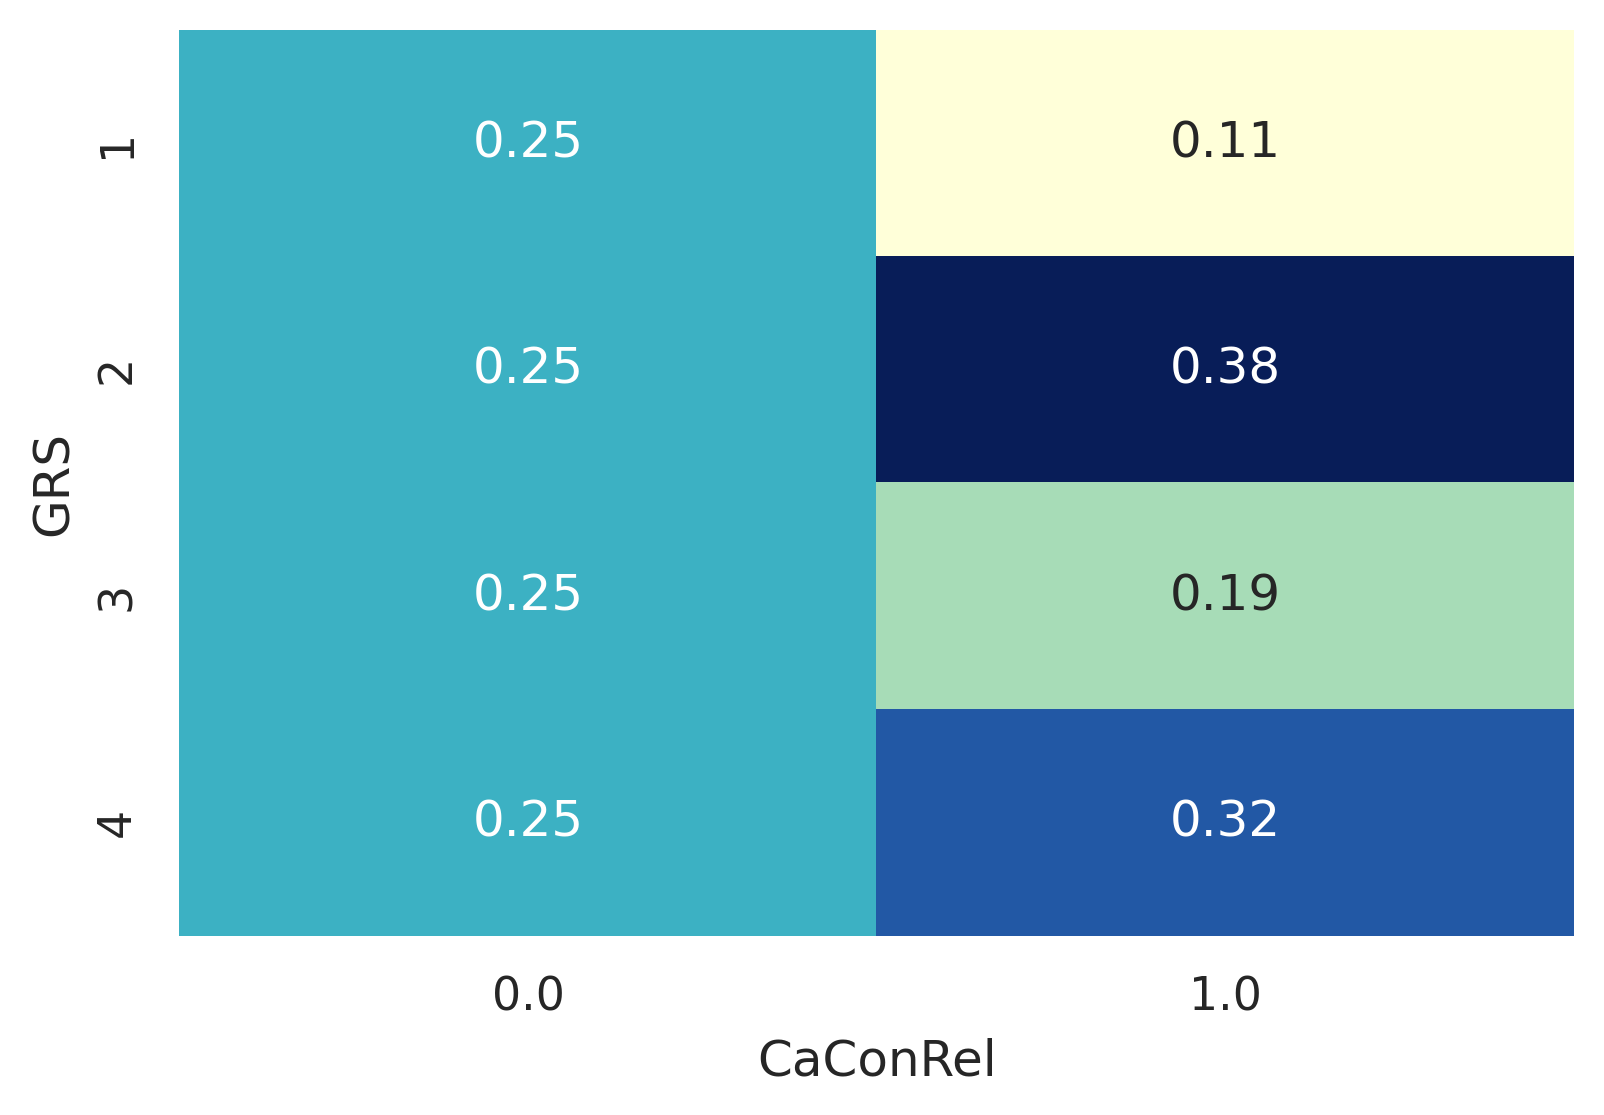

In [ ]:
# Percentages of cases and controls in each GRS group

sns.heatmap(pd.crosstab(a['GRS'],a['CaConRel'],normalize='columns'),
            cmap="YlGnBu", annot=True, cbar=False)

In [ ]:
# Getting dummy variables for the categorical variable GRS_TG

GRS_TG_dum = pd.get_dummies(GRS_TG, drop_first=True, prefix="GRS")

x2 = GRS_TG_dum
y2 = logreg_ytrain.reset_index()


In [ ]:
x2_index = x2.set_index(x_conc.index)

In [ ]:
# Fitting Logistic Regression Model

x2 = sm.add_constant(x2)
reg_log2 = sm.Logit(y2['CaConRel'],x2.reset_index(drop= True))
results_log2 = reg_log2.fit()

Optimization terminated successfully.
         Current function value: 0.561912
         Iterations 6


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
results_log2.summary(alpha=0.1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               CaConRel   No. Observations:                  175
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Dec 2022   Pseudo R-squ.:                 0.03424
Time:                        12:26:33   Log-Likelihood:                -98.335
converged:                       True   LL-Null:                       -101.82
Covariance Type:            nonrobust   LLR p-value:                   0.07279
==============================================================================
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
const         -1.8563      0.481     -3.860      0.000      -2.647      -1.065
GRS_2          1.2809      0.564      2.271      0.023       0.353       2.209
GRS_3          0.5878      0.611      0.962      0.336      -0.418       1.593
GRS_4          1.0986      0.574      1.915      0.056       0.155       2.042
==============================================================================
"""

In [ ]:
# Calculating odds ratios from exponential values of the coefficients

df2 = pd.read_html(results_log2.summary().tables[1].as_html(),header=0,index_col=0)[0]
np.exp(df2['coef'].values)

array([0.15624969, 3.59987816, 1.800024  , 2.99996313])

In [ ]:
# Calculating confidence intervals from exponential values of the coefficients

conf_int_res2 = results_log2.conf_int(alpha=0.1)
np.exp(conf_int_res2.values)

array([[0.07084345, 0.3446199 ],
       [1.42375163, 9.10271129],
       [0.65861948, 4.91938073],
       [1.16755244, 7.70843323]])